#                     **Pneumonia detection using chest-xrays** #

#### Experiments with Transfer Learning using ResNet50V2,InceptionV3, and MobileNetv2

* All the models use similar structure with 1024->512->256->2 nodes with softmax activation and 0.5 dropout between the layers. No special tuning done for any model.
* Adam optimizer with learning rate of 0.00003 is applied.
* Number of epochs = 10
* batch size = 64
* MobileNetv2 seems to get better accuracy and loss stabilization more quickly than the other two. It is also best performing. Note that all the models had recall of 100% for the detection case. False negatives were reported by all the models, though at varing rate.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras import layers
from tensorflow.keras.optimizers import Adam

num_classes = 2
EPOCHS = 10
LR = 0.00003
BATCH_SIZE = 64


In [3]:

def build_model(model_chosen):
    print(model_chosen)
    if model_chosen == 'ResNet50V2':
        pre_trained_model = ResNet50V2(input_shape = (224, 224, 3), include_top = False, pooling = 'avg', weights = 'imagenet')
    if model_chosen == 'InceptionV3':
        pre_trained_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, pooling = 'avg', weights = 'imagenet')
    if model_chosen == 'MobileNetV2':
        pre_trained_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, pooling = 'avg', weights = 'imagenet')

    for layer in pre_trained_model.layers: 
        layer.trainable = False

    final_layer = pre_trained_model.layers[-1]
    print('final layer output shape: ', final_layer.output_shape)
    final_output = final_layer.output
    x = layers.Flatten()(final_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)                  
    x = layers.Dense  (512, activation='relu')(x)           
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense  (256, activation='relu')(x)           
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense  (num_classes, activation='softmax')(x) 

    my_new_model = Model( pre_trained_model.input, x) 

    my_new_model.compile(optimizer = Adam(lr=LR), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])

    my_new_model.summary()
    return my_new_model

In [4]:
TRAIN_DIR = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
TEST_DIR = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/'
VAL_DIR = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/'

In [5]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input

image_size = 224
def generate_data_sets(preprocess_input):
    data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


    train_generator = data_generator.flow_from_directory(
            TRAIN_DIR,
            target_size=(image_size, image_size),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    validation_generator = data_generator.flow_from_directory(
            VAL_DIR,
            target_size=(image_size, image_size),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    test_generator = data_generator.flow_from_directory(
        directory = TEST_DIR,
        target_size = (image_size, image_size),
        batch_size = 1,
        class_mode = None,
        shuffle = False,
        seed = 101
    )
    return train_generator, validation_generator, test_generator


In [6]:
def fit_model(my_new_model,train_generator,validation_generator ):
    history_model = my_new_model.fit(
            train_generator,
            epochs = EPOCHS,
            steps_per_epoch=len(train_generator),
            validation_data=validation_generator,
            validation_steps=len(validation_generator))
    return history_model

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_metrics(history_model, model_chosen):
    plt.figure(1, figsize = (20,10)) 
    plt.subplot(221)  
    plt.plot(history_model.history['accuracy'])  
    plt.plot(history_model.history['val_accuracy'])  
    plt.title(model_chosen+': model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 

    plt.subplot(222)  
    plt.plot(history_model.history['loss'])  
    plt.plot(history_model.history['val_loss'])  
    plt.title(model_chosen+':model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 

    plt.show()

In [8]:
import numpy as np
def model_predict(my_new_model, test_generator):
    test_generator.reset()
    pred = my_new_model.predict(test_generator, steps = len(test_generator), verbose = 1)
    predicted_class_indices = np.argmax(pred, axis = 1)
    return predicted_class_indices

In [9]:
from sklearn.metrics import classification_report,confusion_matrix
def generate_confusion_matrix(predicted_class_indices, test_generator, model_chosen):
    print(model_chosen, model_chosen, model_chosen, model_chosen, model_chosen )
    print("###########################################################")
    import cv2
    f, ax = plt.subplots(4, 4, figsize = (20, 20))
    
    # Generate confusion matrix using the information from filename and the predicted_class. Also plot the test images with correct labels and 
    # predicted labels
    
    y_test = [0] * len(test_generator)
    for i in range(0,len(test_generator)):

        fname = TEST_DIR + test_generator.filenames[i]
        aname = fname.split('/')[6]
        imgBGR = cv2.imread(fname)
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        if aname == 'PNEUMONIA':
            y_test[i] = 1   # set the target label to 1

        # Pneumonia if class is set to 1 else Normal
        predicted_class = "PNEUMONIA" if predicted_class_indices[i] else "NORMAL "
        ax[i//4, i%4].imshow(imgRGB)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("Predicted:{} * Actual:{}".format(predicted_class, aname))   
    plt.show()
    print(confusion_matrix(y_test,predicted_class_indices ))  
    print(classification_report(y_test,predicted_class_indices )) 
    print("###########################################################")



## ResNet50V2 ##

ResNet50V2
94674944/94668760 [==============================] - 1s 0us/step
final layer output shape:  (None, 2048)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0

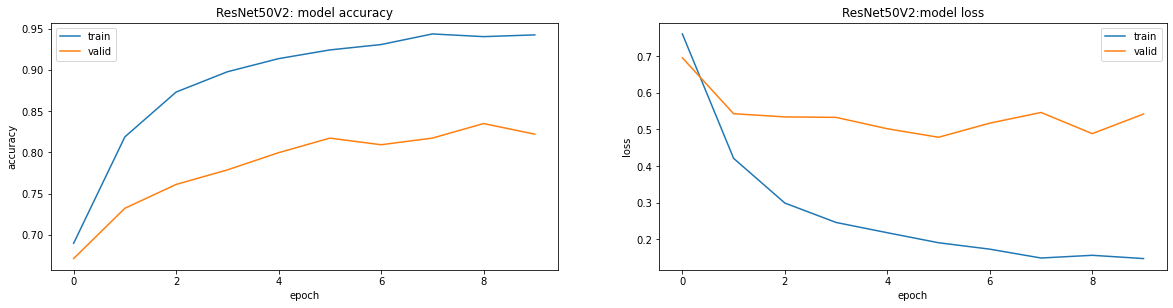

16/16 [==============================] - 1s 19ms/step
ResNet50V2 ResNet50V2 ResNet50V2 ResNet50V2 ResNet50V2
###########################################################


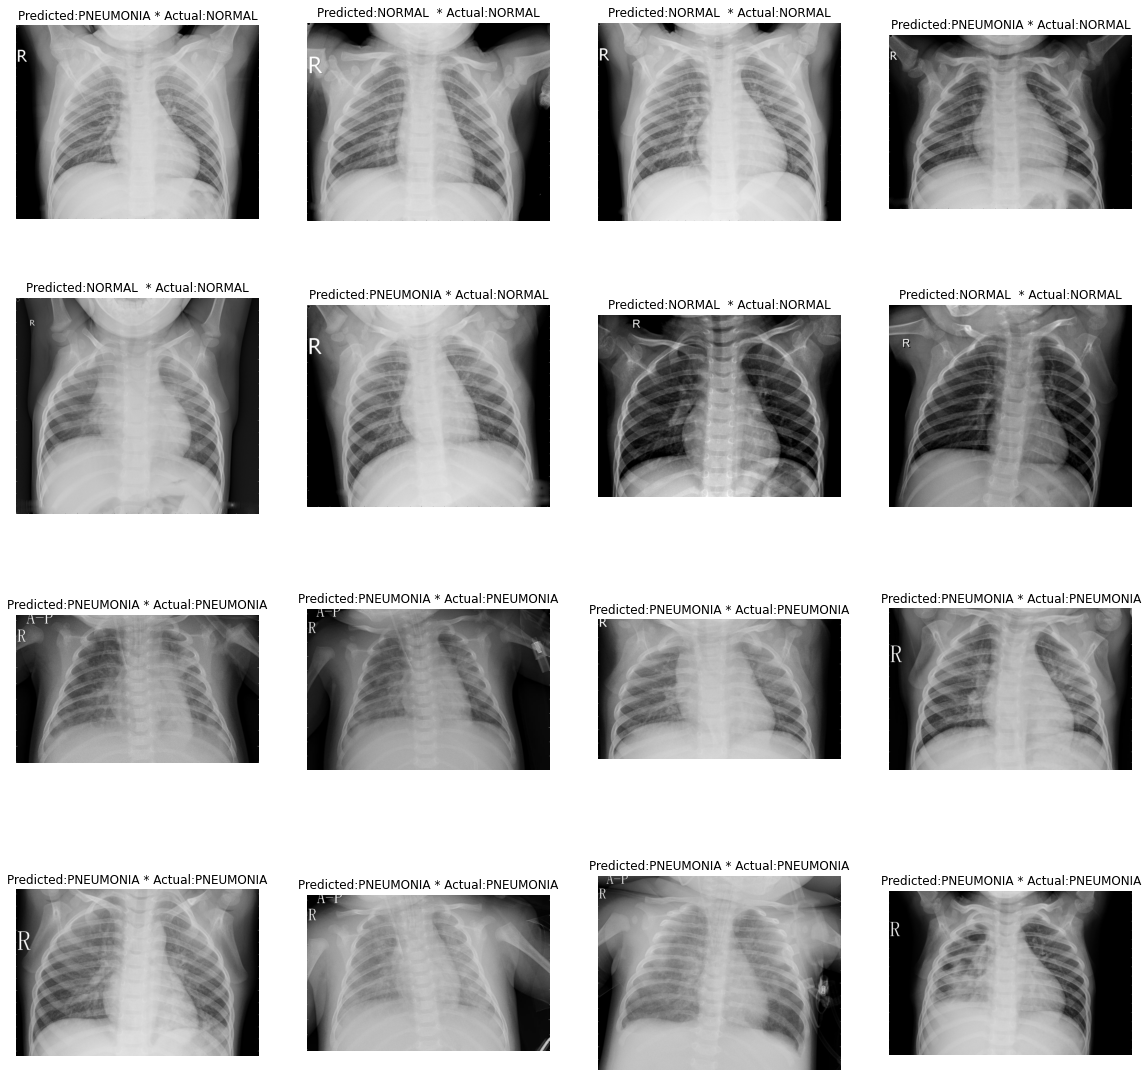

[[5 3]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16

###########################################################


In [10]:
model_chosen = 'ResNet50V2'
from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
my_new_model = build_model(model_chosen)
train_generator, validation_generator, test_generator = generate_data_sets(preprocess_input)
history_resnet = fit_model(my_new_model,train_generator,validation_generator )
plot_metrics(history_resnet, model_chosen)
predicted_class_indices = model_predict(my_new_model, test_generator)
generate_confusion_matrix(predicted_class_indices, test_generator, model_chosen)


## InceptionV3

InceptionV3
87916544/87910968 [==============================] - 1s 0us/step
final layer output shape:  (None, 2048)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_nor

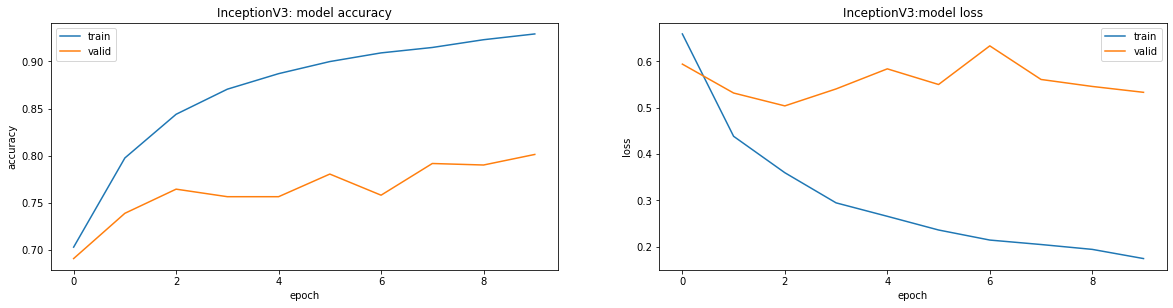

16/16 [==============================] - 2s 19ms/step
InceptionV3 InceptionV3 InceptionV3 InceptionV3 InceptionV3
###########################################################


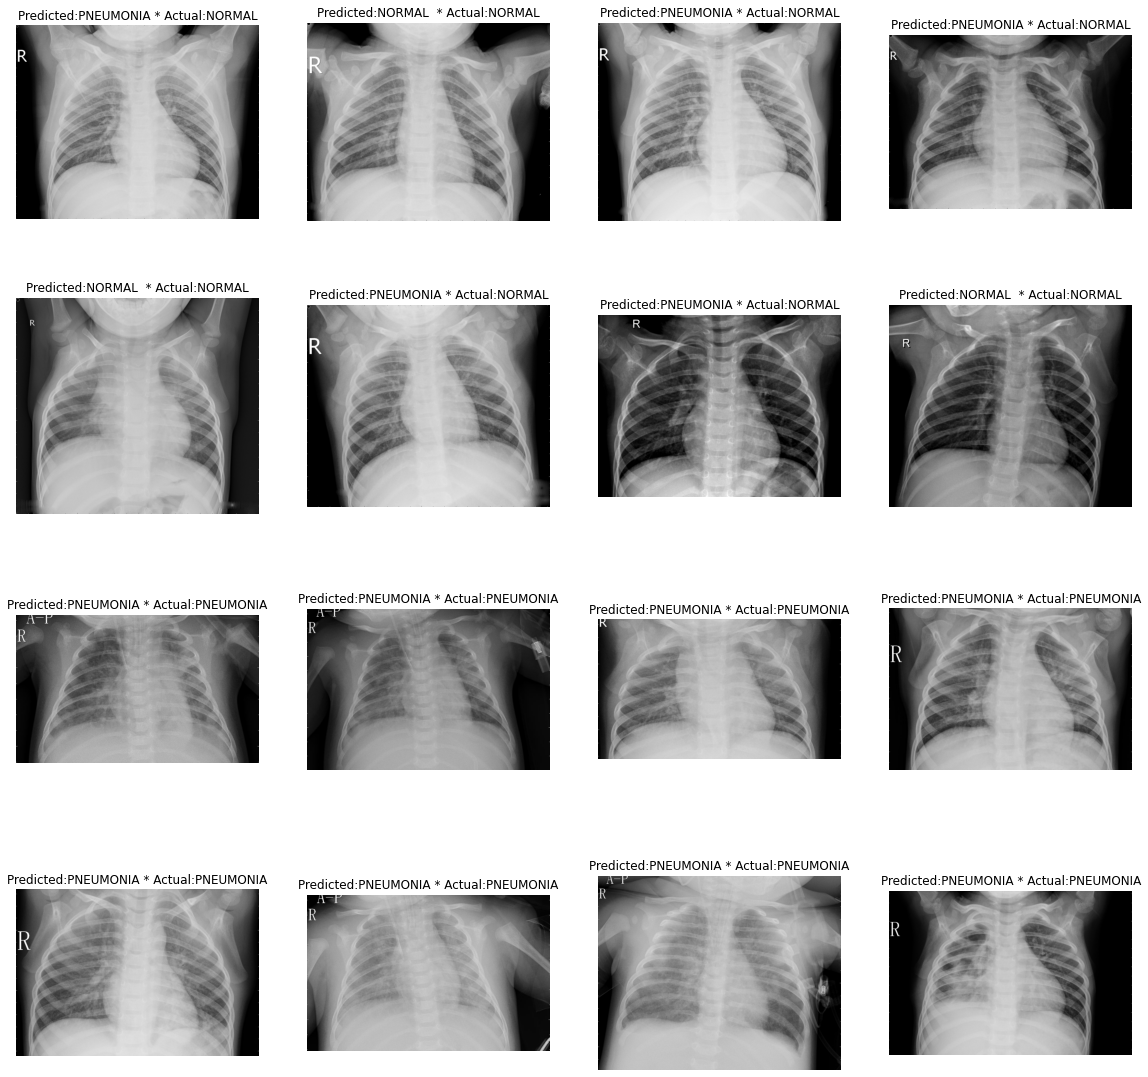

[[3 5]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16

###########################################################


In [11]:
model_chosen = 'InceptionV3'
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
my_new_model = build_model(model_chosen)
train_generator, validation_generator, test_generator = generate_data_sets(preprocess_input)
history_inception = fit_model(my_new_model,train_generator,validation_generator )
plot_metrics(history_inception, model_chosen)
predicted_class_indices = model_predict(my_new_model, test_generator)
generate_confusion_matrix(predicted_class_indices, test_generator, model_chosen)



## MobileNetV2

MobileNetV2
9412608/9406464 [==============================] - 0s 0us/step
final layer output shape:  (None, 1280)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0]

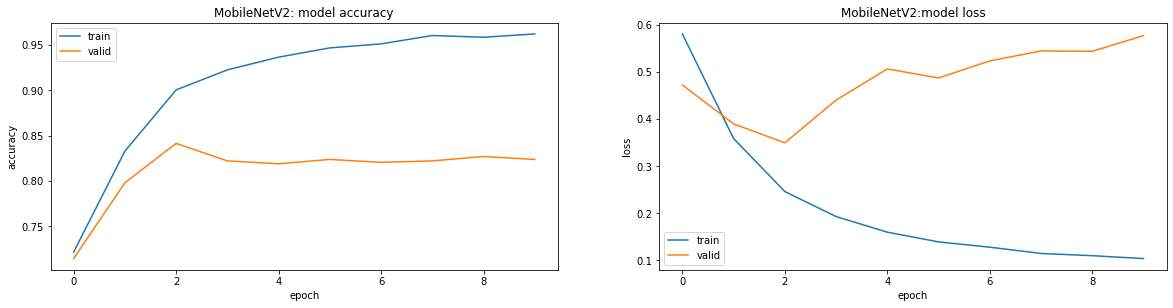

16/16 [==============================] - 1s 11ms/step
MobileNetV2 MobileNetV2 MobileNetV2 MobileNetV2 MobileNetV2
###########################################################


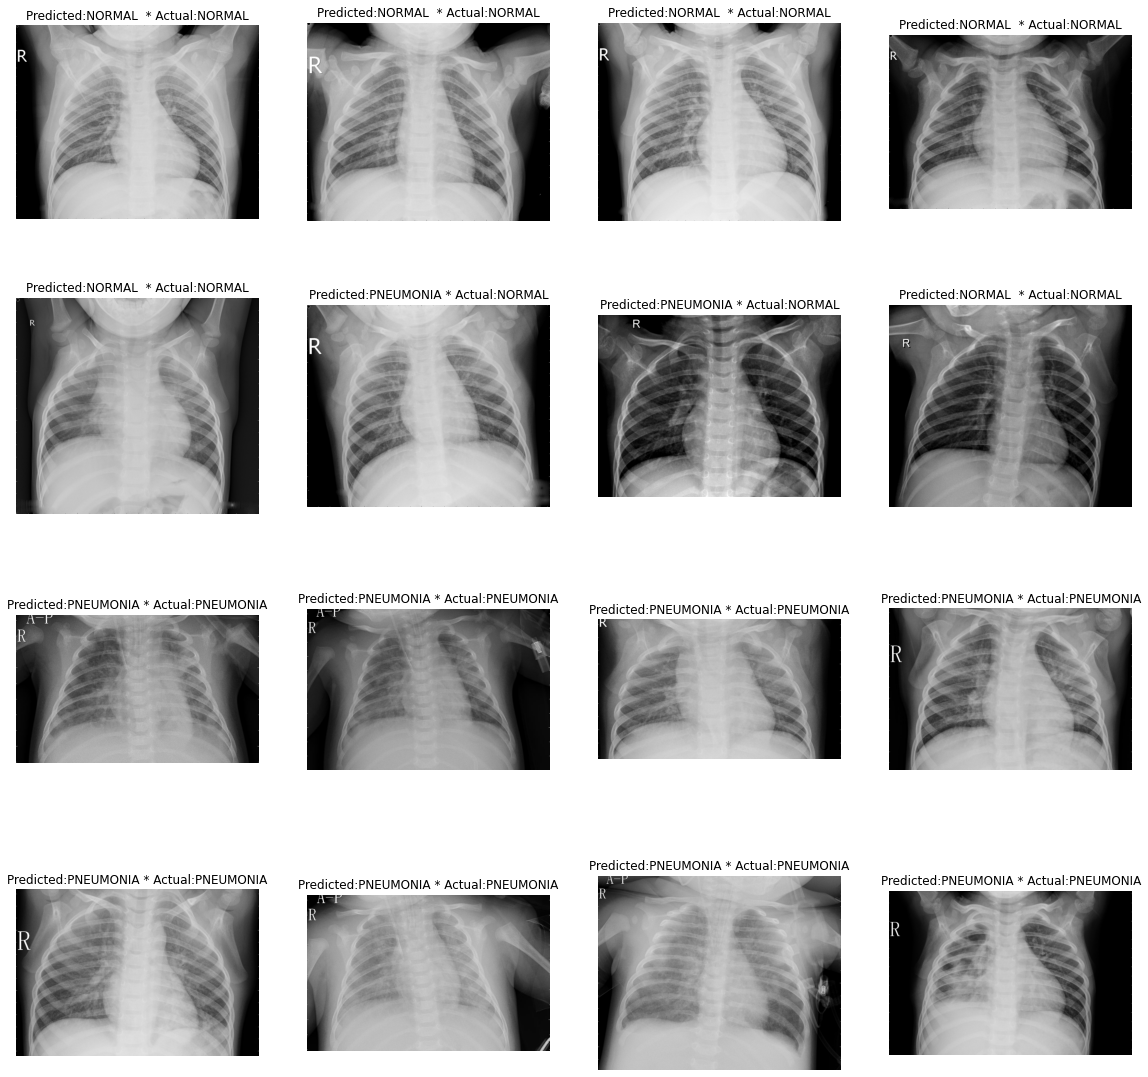

[[6 2]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

###########################################################


In [12]:

model_chosen = 'MobileNetV2'
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
my_new_model = build_model(model_chosen)
train_generator, validation_generator, test_generator = generate_data_sets(preprocess_input)
history_mobilenet = fit_model(my_new_model,train_generator,validation_generator )
plot_metrics(history_mobilenet, model_chosen)
predicted_class_indices = model_predict(my_new_model, test_generator)
generate_confusion_matrix(predicted_class_indices, test_generator, model_chosen)



## Plot all the models'  metrics - loss and accuracy 

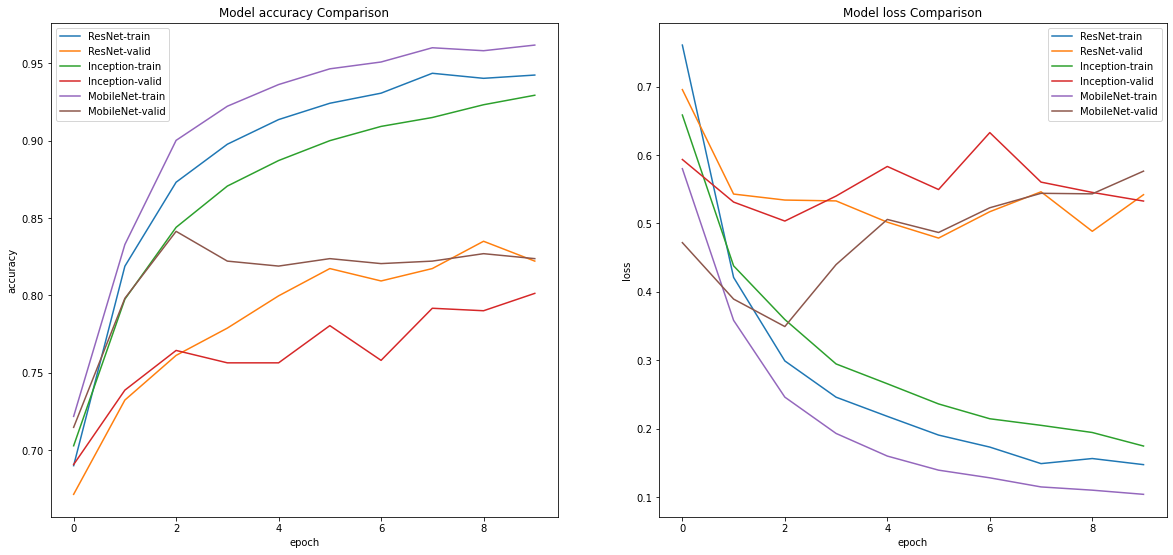

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(1, figsize = (20,20)) 
plt.subplot(221) 
plt.plot(history_resnet.history['accuracy'])  
plt.plot(history_resnet.history['val_accuracy']) 
plt.plot(history_inception.history['accuracy'])  
plt.plot(history_inception.history['val_accuracy'])
plt.plot(history_mobilenet.history['accuracy'])  
plt.plot(history_mobilenet.history['val_accuracy'])

plt.title('Model accuracy Comparison')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['ResNet-train', 'ResNet-valid', 'Inception-train', 'Inception-valid','MobileNet-train', 'MobileNet-valid']) 
    
plt.subplot(222)
plt.plot(history_resnet.history['loss'])  
plt.plot(history_resnet.history['val_loss']) 
plt.plot(history_inception.history['loss'])  
plt.plot(history_inception.history['val_loss'])  
plt.plot(history_mobilenet.history['loss'])  
plt.plot(history_mobilenet.history['val_loss'])  
plt.title('Model loss Comparison')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['ResNet-train', 'ResNet-valid', 'Inception-train', 'Inception-valid','MobileNet-train', 'MobileNet-valid']) 

plt.show()